# Miriade DataGame

### Introduzione
Salve! Mi presento, mi chiamo Lorenzo Palloni, studente del corso di laurea triennale in Statistica all'Università degli Studi di Firenze. Questa è la mia seconda partecipazione ad una competizione di Bee-Viva e devo dire che è sempre un piacere partecipare.

Di seguito riporto il codice, commentato, che ho utilizzato.

#### Librerie
```python
from my_functions import *    # funzioni "self-made"
import pandas as pd    # per la gestione dei dataframe
import numpy as np    # per le operazioni matematiche
from dateutil.parser import parse    # per la gestione delle variabili di tipo "datetime" 
from scipy import stats    # per il calcolo del valore modale
from sklearn.model_selection import GridSearchCV    # per la selezione degli iperparametri del modello
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier    # modelli Random Forest
from sklearn.metrics import mean_squared_log_error    # per la funzione di score
from sklearn.model_selection import train_test_split    # per la validazione
import matplotlib.pyplot as plt    # per le funzioni grafiche
```
#### La costante RANDOM_STATE mi servirà più avanti per ottenere risultati delle funzioni di split del dataset e fit del modello 
```python
RANDOM_STATE = 42
```

#### Importo il dataset di train e il dataset di test.
```python
train = pd.read_csv("../data/dataset_stima.csv")
test = pd.read_csv("../data/dataset_previsione.csv")
test_copy = test.copy(deep=True)
```

#### Elimino le osservazioni associate ai valori negativi della variabile NUMERO_CLICK_SITO.
```python
train.drop(train[train.NUMERO_CLICK_SITO < 0].index, inplace=True)
```

#### Assegno il valore **mediano** ai missing value della variabile DATA
```python
date_nulle = train.DATA.isnull()
date_non_nulle = [not i for i in date_nulle]

dates = list(train['DATA'][date_non_nulle].sort_values())
mediana_data = dates[len(dates)//2]
train.loc[date_nulle, 'DATA'] = mediana_data
```

#### Assegno il valore **modale** ai missing value della variabile PUBBLICITA 

```python
# imputazione valore modale alla variabile PUBBLICITA per i valore mancanti
moda_PUBBLICITA = stats.mode(train['PUBBLICITA'])
train['PUBBLICITA'] = train['PUBBLICITA'].fillna(int(moda_PUBBLICITA.mode))
```

#### Sostituisco i valori mancanti della variabile TIPO_PUBBLICITA con quelli previsti da un modello random forest.

```python
tipo_nan = train['TIPO_PUBBLICITA'].isnull()
tipo_nonan = [not i for i in tipo_nan]

X_tipo = pd.concat([train['MACRO_TIPO_PUBBLICITA'].astype('category'),
                    train['FASCIA_ORARIA'].astype('category'),
                    train['FASCIA_TEMPISTICA'].astype('category'), axis=1)

X_tipo = X_tipo.loc[train['TIPO_PUBBLICITA'][tipo_nonan].index]
y_tipo = train['TIPO_PUBBLICITA'][train['TIPO_PUBBLICITA'][tipo_nonan].index]

tipo_model = RandomForestClassifier(n_estimators=75, random_state=RANDOM_STATE)
tipo_model.fit(X_tipo, y_tipo)
X_tipo_test = pd.concat([train['MACRO_TIPO_PUBBLICITA'].astype('category'),
                    train['FASCIA_ORARIA'].astype('category'),
                    train['FASCIA_TEMPISTICA'].astype('category'), axis=1)

test_tipo = X_tipo_test.loc[train['TIPO_PUBBLICITA'][tipo_nan].index]
tipo_pred = tipo_model.predict(test_tipo)
train.loc[tipo_nan, 'TIPO_PUBBLICITA'] = tipo_pred
```
####  Per trainare il modello ho utilizzato le seguenti variabili:
 - MACRO_TIPO_PUBBLICITA
 - FASCIA_ORARIA
 - FASCIA_TEMPISTICA
 
#### I seguenti grafici mostrano una certa causalità fra le variabili selezionate e la variabile risposta TIPO_PUBBLICITA:
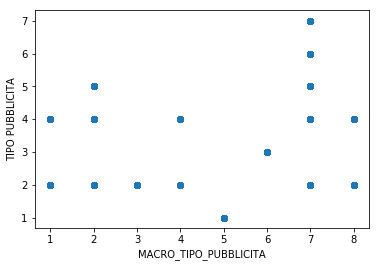

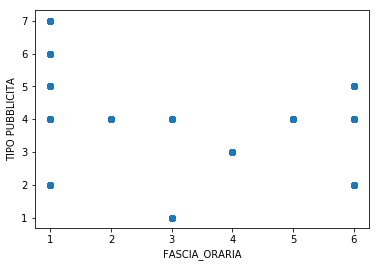

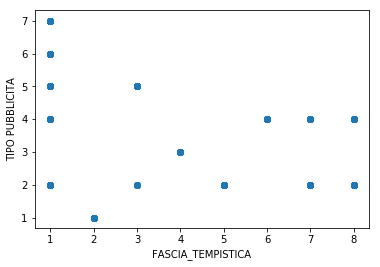

#### La funzione "fix_vars" assegna il type appropriato alle variabili che non lo avevano. Per esempio, la variabile CODICE_GIOCO quando importata viene vista come variabile quantitativa e quindi va opportunamente specificato che si tratta di una variabile categorica.
```python
train = fix_vars(train)
test = fix_vars(test)
```

#### "fix_inizio_fine" controlla se le date della variabile INIZIO_PUBBLICITA sono minori della variabile FINE_PUBBLICITA e viceversa. Se il controllo ha successo, le due date vengono scambiate.
```python
train = fix_inizio_fine(train)
test = fix_inizio_fine(test)
```

#### La funzione "fix_data_limit" controlla se la variabile DATA rispetta correttamente i limiti dati dalle due variabili INIZIO_PUBBLICITA e FINE_PUBBLICITA. Se il controllo ha successo viene scambiato il valore della variabile DATA con quello della variabile i cui limiti sono superati.
```python
train = fix_data_limit(train)
test = fix_data_limit(test)
```

#### Seleziono le variabili per la previsione
```python

X = train.iloc[:, [0, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16]]
y = train.iloc[:, 11]

X_test = test.iloc[:, [0, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]]
```

#### Lista variabili (nome, indice del train, indice del test):
 - 'PUBBLICITA', 0, 0
 - 'INIZIO_PUBBLICITA', 1, 1
 - 'FINE_PUBBLICITA', 2, 2
 - 'MACRO_TIPO_PUBBLICITA', 3, 3
 - 'FASCIA_ORARIA', 4, 4
 - 'FASCIA_TEMPISTICA', 5, 5
 - 'TIPO_PUBBLICITA', 6, 6
 - 'DATA', 7, 7
 - 'CODICE_GIOCO', 8, 8
 - 'RILANCIO_PUBBLICITA', 9, 9
 - 'SESSIONE', 10, 10
 - 'NUMERO_CLICK_SITO', 11, (magari!)
 - 'OFFERTA_PROMOZIONALE', 12, 11
 - 'MACRO_CATEGORIA_GIOCO', 13, 12
 - 'MICRO_CATEGORIA_GIOCO', 14, 13
 - 'AREA_CLICK', 15, 14
 - 'NUMERO_PUBBLICITA_CONCORRENTI', 16, 15
 - 'ID', 17, 16

#### Splittando il train dataset in 85% train set e 15% validation set così da fare varie prove per capire quali variabili usare e se quelle aggiunte possono migliorare il training del modello.
```python
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.85, test_size=0.15, random_state=RANDOM_STATE)

rf_model = RandomForestRegressor(n_estimators=75, n_jobs=-1, random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)
y_pred_validation = rf_model.predict(X_validation)
```

```python
msle_validation = mean_squared_log_error(y_validation, y_pred_validation)
score_validation = score_fun(y_pred_validation, y_validation)
print("score validation: ", score_validation, "\nmsle: ", msle_validation)
```

#### Tuning iperparametri random forest con una grid search che, data una lista di valori di alcuni parametri del modello, restituisce quelli che ottimizzano la funzione di loss che gli viene fornita (in questo caso la mean squared log error).
```python

# numero di features considerate ad ogni split
max_features = ['auto', 'sqrt']
# massimo numero di livelli di profondità degli alberi
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# dimensione minima del campione richiesta prima di ogni split
min_samples_split = [2, 5, 10]
# dimensione minima del campione richiesta in ogni foglia
min_samples_leaf = [5, 10]

param_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

param_grid
```

    {'max_depth': [10, 60, 110, None],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [5, 10],
     'min_samples_split': [2, 5, 10]}

```python
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2,
                           scoring='neg_mean_squared_log_error')
```

```python
grid_search.fit(X_train, y_train)
```
#### Fra i valori forniti per i parametri, i migliori con il metodo grid search sono i seguenti:
```python
grid_search.best_params_
```

    {'max_depth': None,
     'max_features': 'auto',
     'min_samples_leaf': 5,
     'min_samples_split': 5}

#### train e previsione con il modello random forest, con 150 decision tree per l'ensemble una dimensione minima di 5 per ogni split e gli altri parametri lasciati default.
```python
rf_model = RandomForestRegressor(n_estimators=150, n_jobs=-1,
                                 random_state=RANDOM_STATE, min_samples_split=5)
rf_model.fit(X, y)
yhat_rf = rf_model.predict(X_test)
```
#### Il grafico seguente mostra l'importanza delle variabili calcolata in base al peso che le features hanno avuto negli split del modello.
```python
# plotting feature importances

var_label, var_importance = X.columns, rf_model.feature_importances_

plt.figure(figsize=(30,15))
plt.barh(var_label, var_importance)
plt.tick_params(labelsize=25)
plt.show()
```
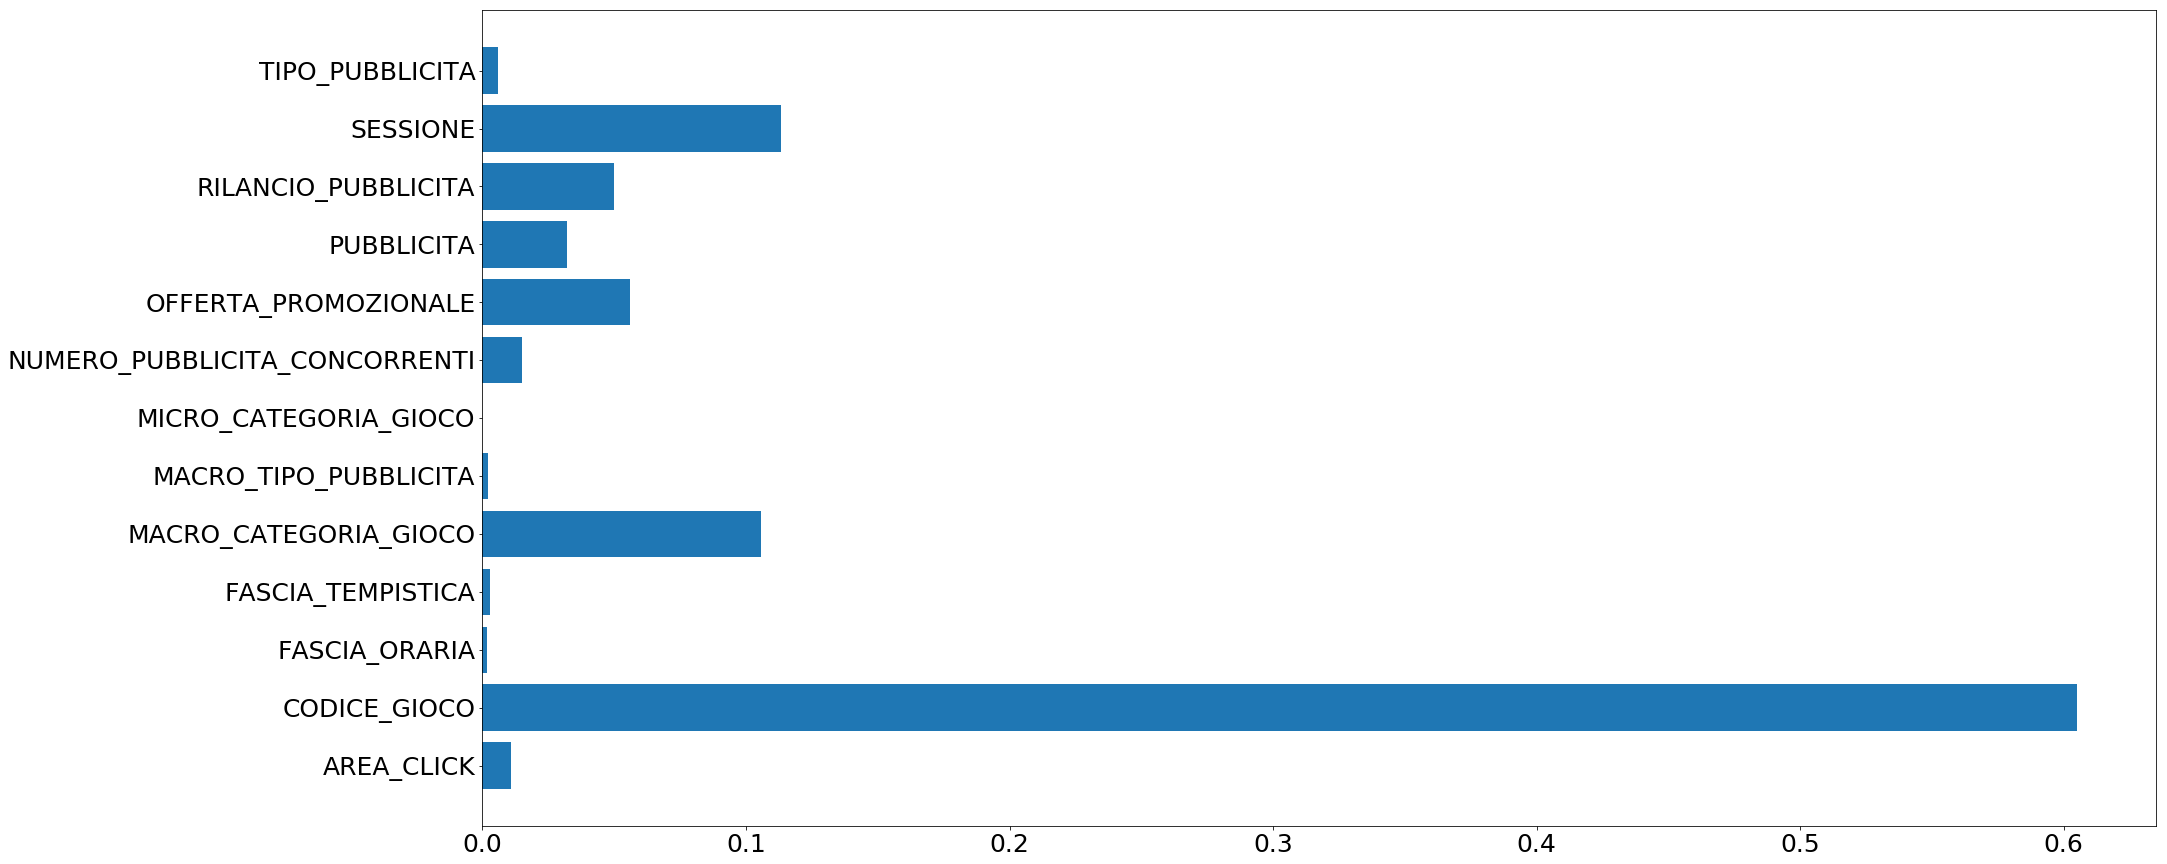
#### "raggruppa" unisce la previsione al test set e raggruppa i dati come indicato nelle istruzioni della competizione.
```python
df_grouped = raggruppa(test= test_copy, yhat= yhat_rf)
```

#### "crea_file_submission" è abbastanza self-explanatory, infatti crea il file per il submission.
```python
crea_file_submission(df_grouped, 24)
```

# Commenti

- Fra le tante prove per ottimizzare la previsione, ho creato due variabili NEW_DOMENICA e NEW_RANGE che ho dovuto togliere perchè non apportavano miglioramenti per "trainare" il modello.
    - NEW_DOMENICA è una variabile dummy che assume valore 1 se nell'osservazione la data assunta dalla variabile DATA è un giorno domenicale 0 altrimenti;
    - NEW_RANGE rappresenta la differenze espressa in numero di giorni fra le date delle vairabili FINE_PUBBLICITA e INIZIO_PUBBLICITA.

- Inoltre avevo intenzione di fare un ensemble di random forest e multiple linear regression, ma la regressione lineare in questo dataset ha altissime probabilità di overfittare. Questo è dovuto al fatto che codificando le variabili categoriche, fra le quali alcune possono assumere range di valori veramente ampi, le variabili alla fine del preprocessing sarebbero arrivate a circa 300.

#### Di seguito ho riportato il file python dove ci sono tutte le funzioni che ho creato per la competizione.


### my_functions.py

```python
import numpy as np
import pandas as pd
from dateutil.parser import parse


def raggruppa(test, yhat):

    # aggiungo colonna delle previsioni al test set fornito
    test_with_yhat = pd.concat([test, pd.Series(yhat)], axis=1)

    # rinomino colonna delle y
    test_with_yhat.columns = ['PUBBLICITA', 'INIZIO_PUBBLICITA',
                              'FINE_PUBBLICITA', 'MACRO_TIPO_PUBBLICITA',
                              'FASCIA_ORARIA', 'FASCIA_TEMPISTICA',
                              'TIPO_PUBBLICITA', 'DATA',
                              'CODICE_GIOCO', 'RILANCIO_PUBBLICITA',
                              'SESSIONE', 'OFFERTA_PROMOZIONALE',
                              'MACRO_CATEGORIA_GIOCO', 'MICRO_CATEGORIA_GIOCO',
                              'AREA_CLICK', 'NUMERO_PUBBLICITA_CONCORRENTI',
                              'ID', 'NUMERO_CLICK_SITO']

    # dizionario "altre variabili" : "funzioni"
    dict_agg = {'INIZIO_PUBBLICITA': np.max,
                'FINE_PUBBLICITA': np.min,
                'SESSIONE': np.median,
                'NUMERO_PUBBLICITA_CONCORRENTI': np.mean,
                'ID': np.max,
                'NUMERO_CLICK_SITO': np.sum,
                'TIPO_PUBBLICITA': np.median,
                'OFFERTA_PROMOZIONALE': np.mean
                }

    # raggruppamento sul train dataset
    df_grouped = test_with_yhat.groupby(['PUBBLICITA', 'CODICE_GIOCO', 'MACRO_TIPO_PUBBLICITA',
                                         'FASCIA_TEMPISTICA', 'FASCIA_ORARIA', 'TIPO_PUBBLICITA',
                                         'MICRO_CATEGORIA_GIOCO', 'RILANCIO_PUBBLICITA', 'AREA_CLICK', 'DATA'])

    df_grouped = df_grouped.agg(dict_agg)
    return df_grouped


def crea_file_submission(df, number):

    df = pd.concat([df['ID'], df['NUMERO_CLICK_SITO']], axis=1)

    df['ID'] = df['ID'].astype('str')
    df['ID'].head()
    df['NUMERO_CLICK_SITO'] = df['NUMERO_CLICK_SITO'].astype('int')
    df.columns = ['ID', 'yhat']

    file = open("submission_{}.txt".format(number), "w")
    for index, row in df.iterrows():
        file.write(str(row['ID']) + " " + str(row['yhat']) + "\n")
    file.close()
    return None


def fix_vars(df):

    # Aggiustamento dtype delle variabili

    df['PUBBLICITA'] = df['PUBBLICITA'].astype('int').astype('category')
    df['MACRO_TIPO_PUBBLICITA'] = df['MACRO_TIPO_PUBBLICITA'].astype('category')
    df['FASCIA_ORARIA'] = df['FASCIA_ORARIA'].astype('category')
    df['FASCIA_TEMPISTICA'] = df['FASCIA_TEMPISTICA'].astype('category')
    df['CODICE_GIOCO'] = df['CODICE_GIOCO'].astype('category')
    df['RILANCIO_PUBBLICITA'] = df['RILANCIO_PUBBLICITA'].astype('int')
    df['SESSIONE'] = df['SESSIONE'].astype('int').astype('category')
    df['MACRO_CATEGORIA_GIOCO'] = df['MACRO_CATEGORIA_GIOCO'].astype('category')
    df['MICRO_CATEGORIA_GIOCO'] = df['MICRO_CATEGORIA_GIOCO'].astype('category')
    df['AREA_CLICK'] = df['AREA_CLICK'].astype('int')
    df['ID'] = df['ID'].astype('int').astype('category')
    df['INIZIO_PUBBLICITA'] = df['INIZIO_PUBBLICITA'].apply(parse)
    df['FINE_PUBBLICITA'] = df['FINE_PUBBLICITA'].apply(parse)
    df['DATA'] = df['DATA'].apply(parse)

    return df


def fix_inizio_fine(df):

    for i, _ in df.iterrows():
        if df['INIZIO_PUBBLICITA'][i] > df['FINE_PUBBLICITA'][i]:
            flag = df['INIZIO_PUBBLICITA'][i]
            df.loc[i, 'INIZIO_PUBBLICITA'] = df['FINE_PUBBLICITA'][i]
            df.loc[i, 'FINE_PUBBLICITA'] = flag
    return df


def fix_data_limit(df):

    for i, _ in df.iterrows():
        if df['DATA'][i] < df['INIZIO_PUBBLICITA'][i]:
            flag_inizio = df['INIZIO_PUBBLICITA'][i]
            df.loc[i, 'INIZIO_PUBBLICITA'] = df['DATA'][i]
            df.loc[i, 'DATA'] = flag_inizio

        if df['DATA'][i] > df['FINE_PUBBLICITA'][i]:
            flag_fine = df['FINE_PUBBLICITA'][i]
            df.loc[i, 'FINE_PUBBLICITA'] = df['DATA'][i]
            df.loc[i, 'DATA'] = flag_fine
    return df
            
            
def score_fun(y_pred, y_true):
    return np.sqrt(np.mean((np.log(y_pred + 1) - np.log(y_true + 1))**2))


def insert_new_domenica(df):

    # vettore giorni 2016
    days_2016 = pd.date_range("2016-01-01", periods=366, freq='d')

    # vettore dummy domenica
    dummy = [0, 0, 1]
    dummy.extend([0, 0, 0, 0, 0, 0, 1] * 52)
    dummy_domenica = dummy[:-1]

    # aggiungo primo dell'anno e vigilia di natale
    dummy_domenica[0] = 1
    dummy_domenica[-8] = 1

    # vettore domenica 2016
    domenica_2016 = []
    for i in range(len(dummy_domenica)):
        if dummy_domenica[i]:
            domenica_2016.append(days_2016[i])

    # aggiungo NEW_DOMENICA al training e al test set
    df['NEW_DOMENICA'] = 0
    for i, _ in df.iterrows():
        if df['DATA'][i] in domenica_2016:
            df.loc[i, 'NEW_DOMENICA'] = 1

    # modifico il tipo in categorica categorica
    df['NEW_DOMENICA'] = df['NEW_DOMENICA'].astype('category')
    return df


def insert_new_range(df):

    df['NEW_RANGE'] = 0
    for i, _ in df.iterrows():
        df.loc[i, 'NEW_RANGE'] = pd.Timedelta(df['FINE_PUBBLICITA'][i] - df['INIZIO_PUBBLICITA'][i]).days
    df['NEW_RANGE'] = df['NEW_RANGE'].astype('int')
    return df
```
